# Fixation map analysis using Gaussian Process

In [1]:
%pylab inline

import numpy as np
import scipy.stats as stats
import pymc3 as pm
from theano import shared
from pymc3.distributions.timeseries import GaussianRandomWalk
from scipy import optimize

%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


Load a fixation dataset (1 subject) and set up experiment specific parameters.

In [2]:
import pandas as pd
Fixtmp = pd.read_csv('fixation_tbl.csv')

# parameters
xSize, ySize = 706, 706
# pixel per-visual degree
# Screen Resolution
Res         = np.array([0., 0., 1920., 1080.])
# Screen  Screen_Size in cm
Screen_Size = np.array([52.128, 29.322])
# View distance of subjects in cm
Distance    = 70.
# Degree per visual angle
from math import atan2, degrees
DPP = degrees(atan2(.5*Screen_Size[0], Distance)) / (.5*Res[2])
pixel_deg = 1/DPP

In [3]:
Fixtmp.head(5)

Unnamed: 0        xfix        yfix      fixdur  fixnum        t0        t1  \
0       70115  597.951361  240.446823  187.134093       1  0.000022  0.187157   
1       70116  372.993165  342.431292  102.641000       2  0.224731  0.327372   
2       70117  343.771177  470.436654  147.038900       3  0.357297  0.504336   
3       70118  338.514308  497.676332  205.823200       4  0.525286  0.731109   
4       70119  341.317094  351.670171  209.525100       5  0.758206  0.967731   

    s0    s1  item   phase    xfix_raw    yfix_raw  
0    1   211  6352  Target  597.951361  240.446823  
1  253   370  6352  Target  372.993165  342.431292  
2  404   570  6352  Target  343.771177  470.436654  
3  594   826  6352  Target  338.514308  497.676332  
4  857  1093  6352  Target  341.317094  351.670171

Get the three variable for fixation mapping: fixation location (x and y) and fixation duration (ms).

In [4]:
xfix    = np.asarray(Fixtmp.xfix)
yfix    = np.asarray(Fixtmp.yfix)
fixdur  = np.asarray(Fixtmp.fixdur)
idx0    = (np.isfinite(xfix)) & (np.isfinite(yfix)) & (np.isfinite(fixdur))
idx1    = np.asarray((Fixtmp['phase'] == 'Target') & idx0)
idx2    = np.asarray((Fixtmp['phase'] == 'Prob') & idx0)

X = np.asarray([xfix[idx1], ySize-yfix[idx1]]).transpose()
Y = np.asarray([fixdur[idx1]]).transpose()

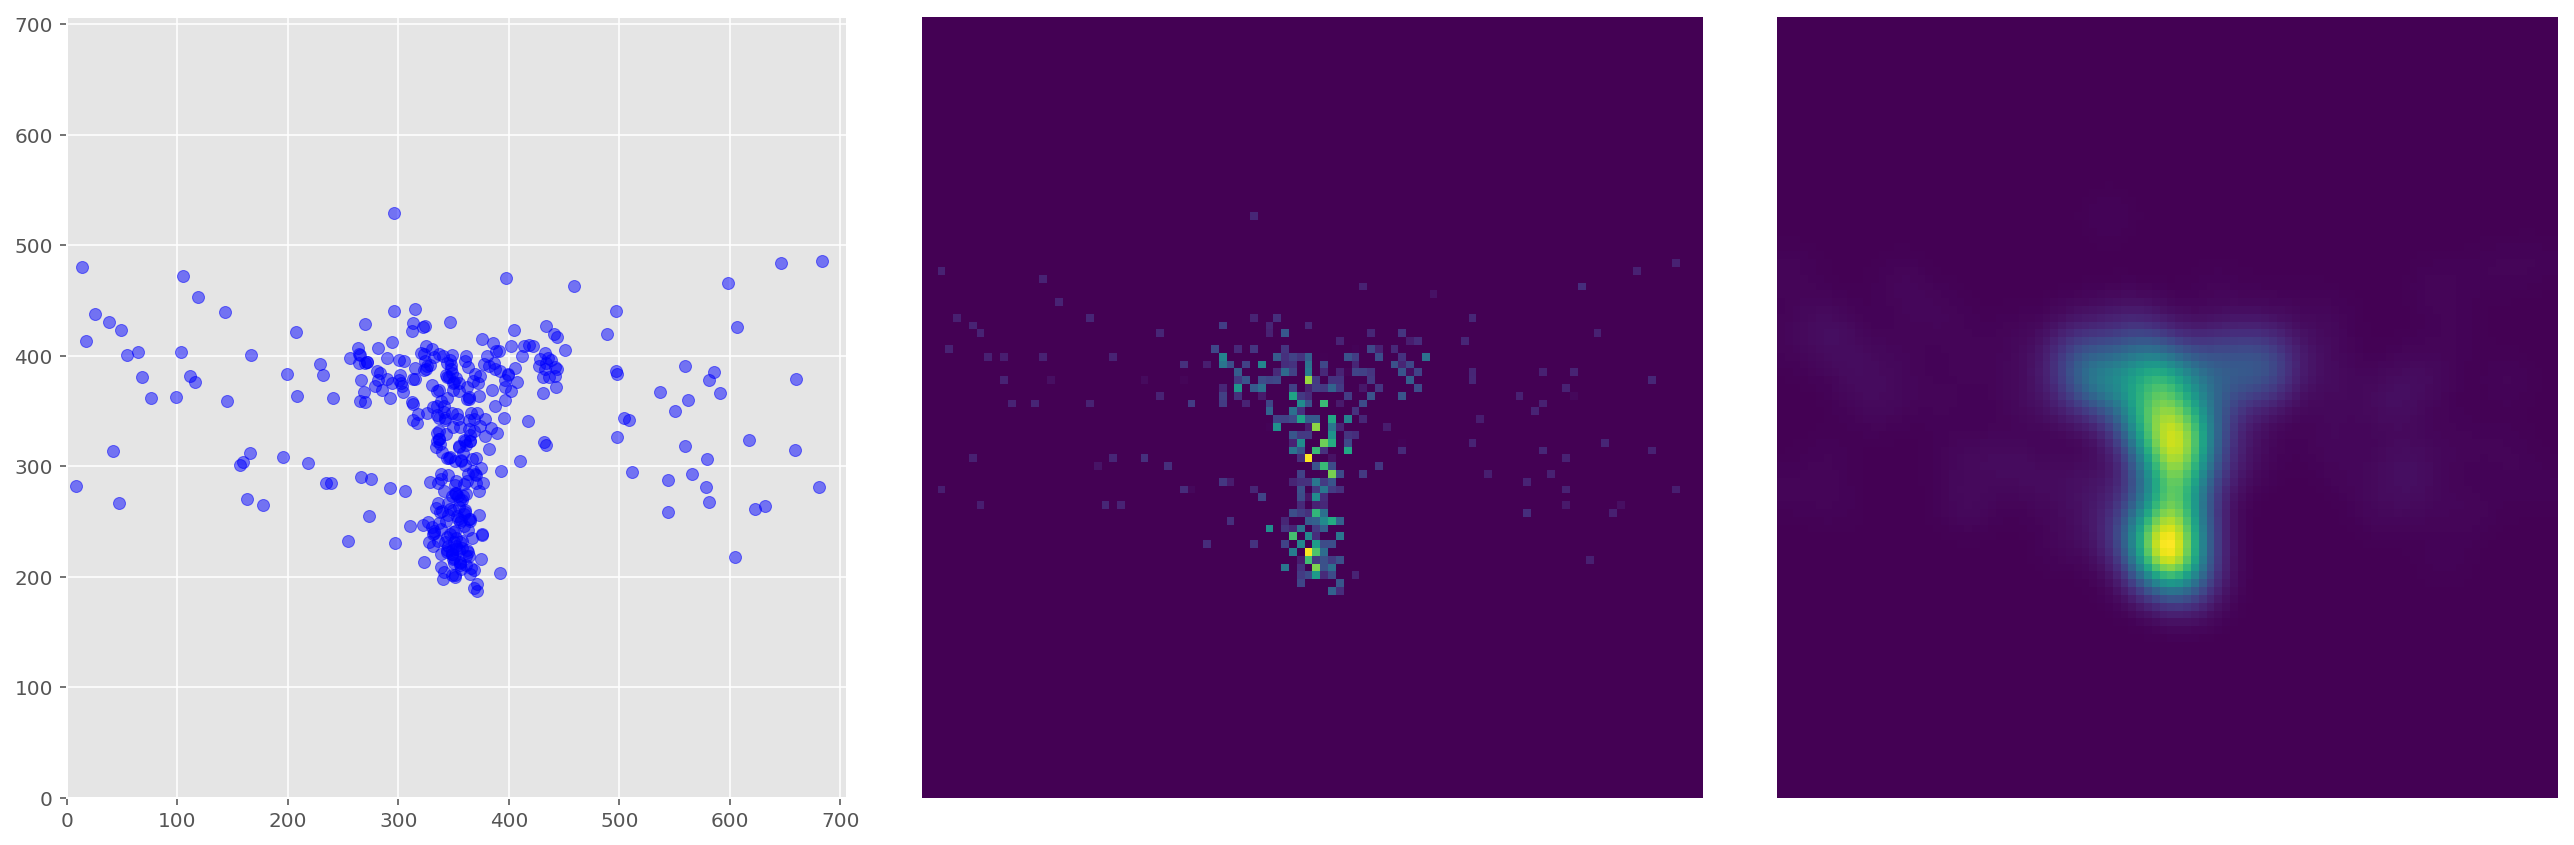

In [5]:
from scipy.sparse import coo_matrix
from scipy.ndimage.filters import gaussian_filter
f, axes1 = plt.subplots(1, 3, figsize=(18, 6))

axes1[0].scatter(xfix[idx1],ySize-yfix[idx1],\
            alpha=.5, color='b')
axes1[0].set(xlim=(0, xSize), ylim=(0, ySize), )
axes1[0].set_aspect('equal')

col = np.asarray(xfix[idx1],dtype=int)
row = np.asarray(yfix[idx1],dtype=int)
dur = np.asarray(fixdur[idx1])
indexnew = (col>=0)&(col<xSize)&(row>=0)&(row<ySize)
rawmap = coo_matrix((dur[indexnew], (row[indexnew], col[indexnew])), shape=(xSize, ySize)).toarray()

xSize_rz, ySize_rz = 100,100
col_rz = np.digitize(xfix[idx1], np.linspace(0,xSize,xSize_rz))
row_rz = np.digitize(yfix[idx1], np.linspace(0,ySize,ySize_rz))
indexnew = (col_rz>=0)&(col_rz<xSize_rz)&(row_rz>=0)&(row_rz<ySize_rz)
rawmaprz = coo_matrix((dur[indexnew], (row_rz[indexnew], col_rz[indexnew])), shape=(xSize_rz, ySize_rz)).toarray()
axes1[1].imshow(rawmaprz,cmap='viridis',interpolation='none')
axes1[1].axis('off')

#from skimage.transform import resize
#smoothpic = gaussian_filter(rawmap, sigma_smooth)
#smoothpic = resize(smoothpic,(xSize_rz, ySize_rz))
fwhm = 1 * pixel_deg
sigma_smooth = fwhm/(2.*np.sqrt(2.*np.log(2.)))
smoothpic = gaussian_filter(rawmaprz, sigma_smooth/(xSize/xSize_rz))
axes1[2].imshow(smoothpic,cmap='viridis',interpolation='none')
axes1[2].axis('off')

f.tight_layout()

The motivation of smoothing here is to account for the measurement noise (.5 degree radius from eye tracker). However, this parameter is arbitrary and fixed by hand.

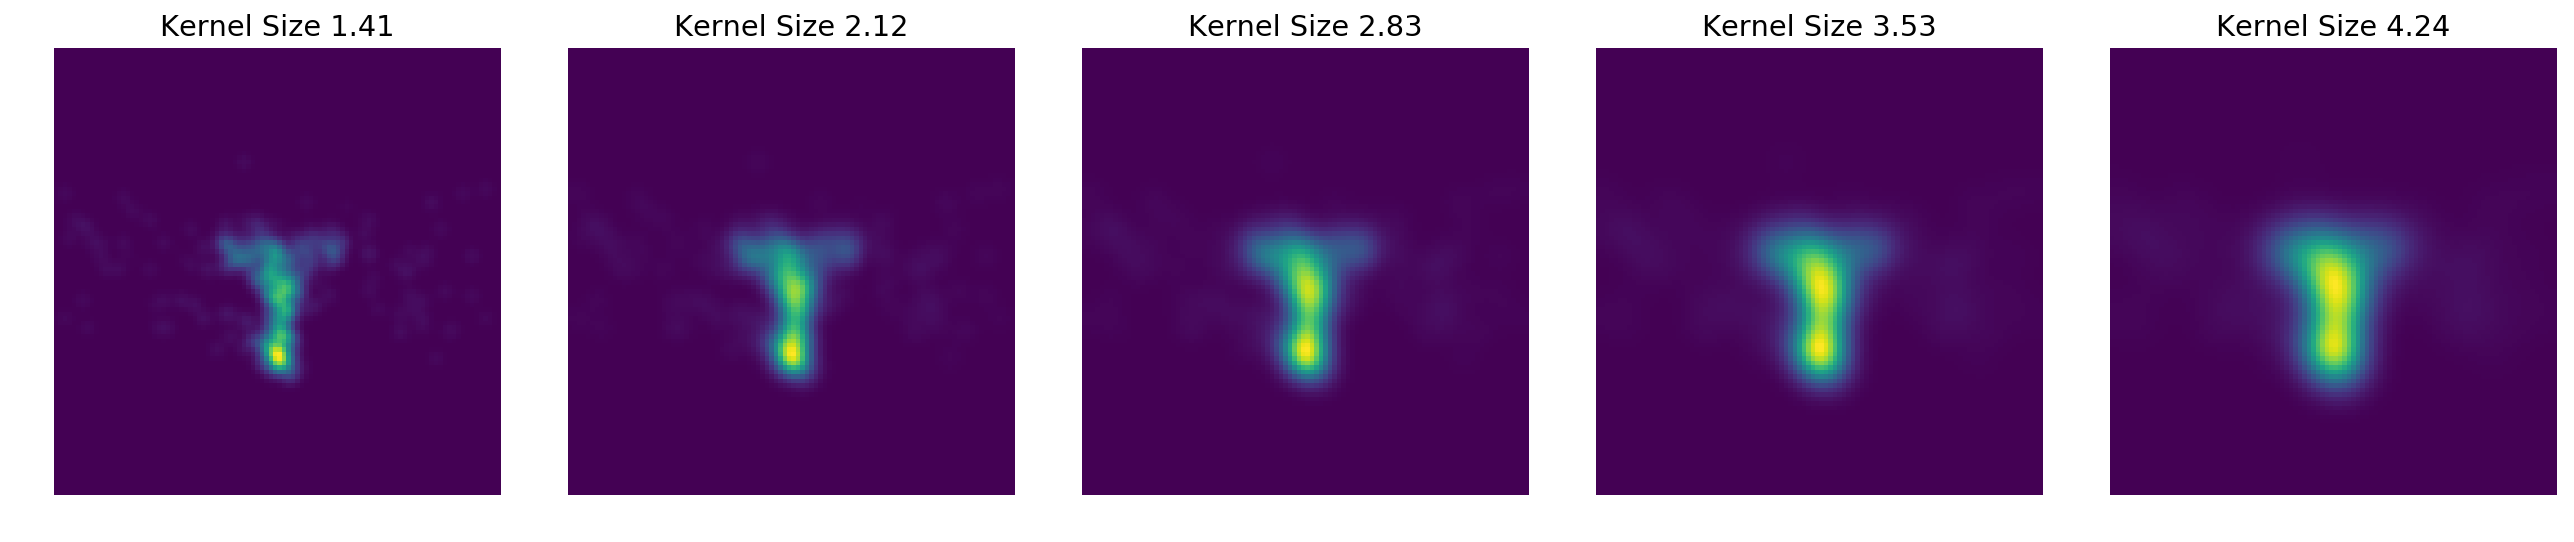

In [6]:
sm_base = fwhm/(2.*np.sqrt(2.*np.log(2.)))/(xSize/xSize_rz)
sm_base *= np.asarray([.5, .75 ,1., 1.25, 1.5])
plt.figure(figsize=(18, 4))
for i, sm in enumerate(sm_base):
    plt.subplot(1,5,i+1)
    
    smoothpic = gaussian_filter(rawmaprz, sm)
    plt.imshow(smoothpic,cmap='viridis',interpolation='none')
    plt.title('Kernel Size %.2f' % sm)
    plt.axis('off')

plt.tight_layout()

Using Gaussian Process for the smoothing

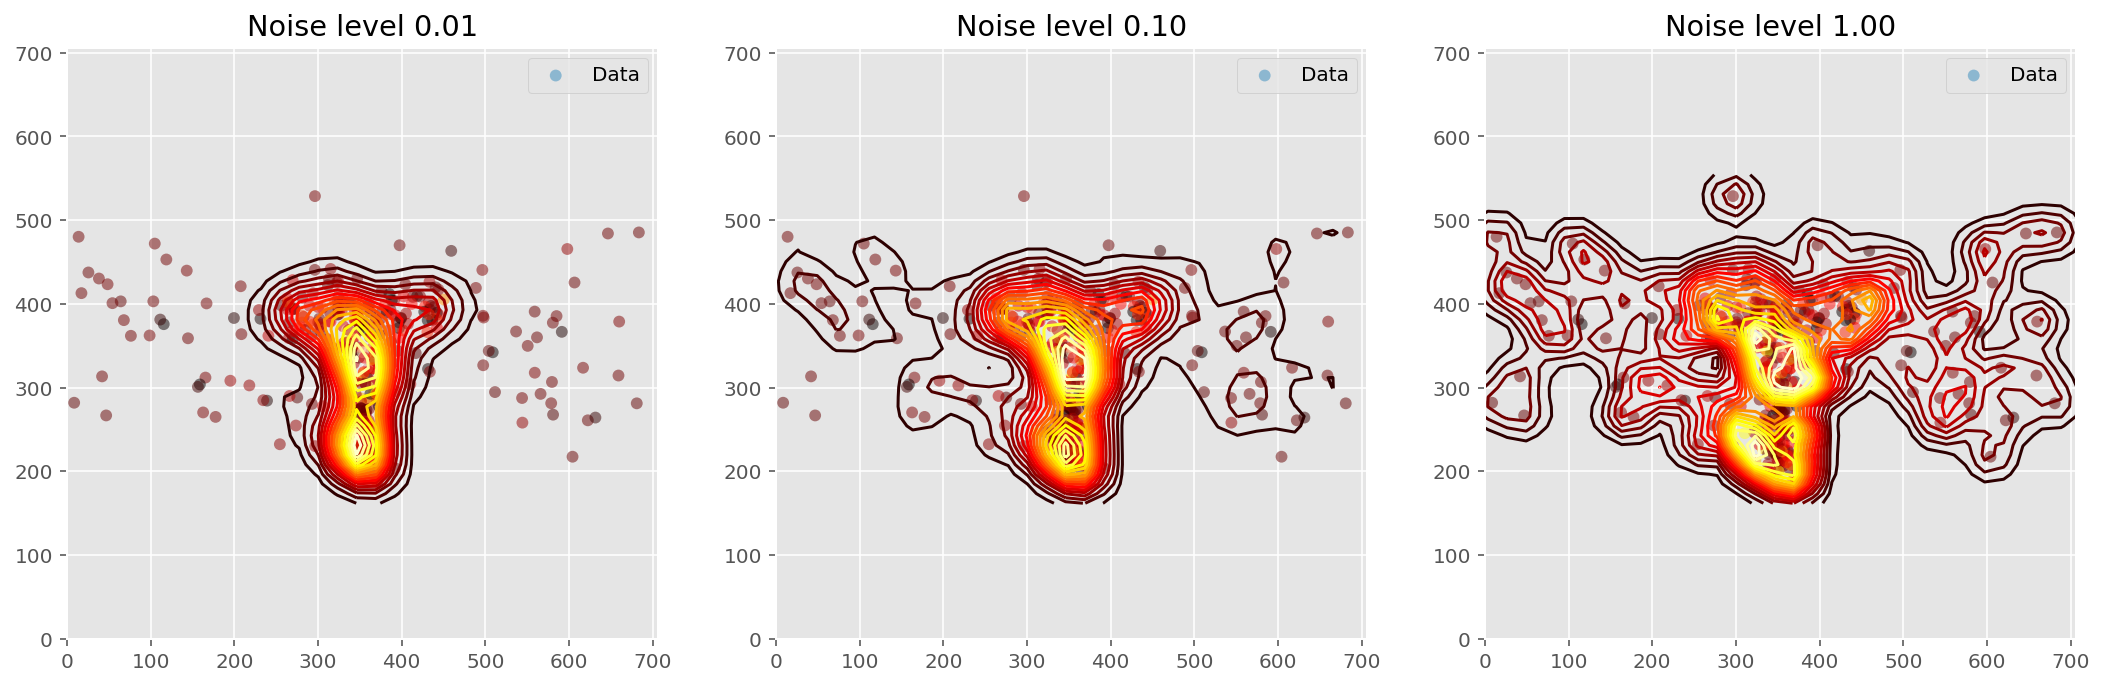

In [7]:
import GPy
ker = GPy.kern.RBF(2,ARD=True)# + GPy.kern.White(2)
# create simple GP model
m = GPy.models.GPRegression(X,Y,ker)
m.kern.lengthscale.fix([sigma_smooth,sigma_smooth])
#m.optimize()
# optimize and plot
_, axes = plt.subplots(1, 3, figsize=(18, 6))
noiselevel = [.01, .1 , 1]
for ip in range(3):
    m.kern.variance.fix(noiselevel[ip])
    m.plot(ax=axes[ip])
    axes[ip].set(xlim=(0, xSize), ylim=(0, ySize))
    axes[ip].set_aspect('equal')
    axes[ip].set_title('Noise level %.2f' % noiselevel[ip])
plt.show()

Naive fitting does not work!

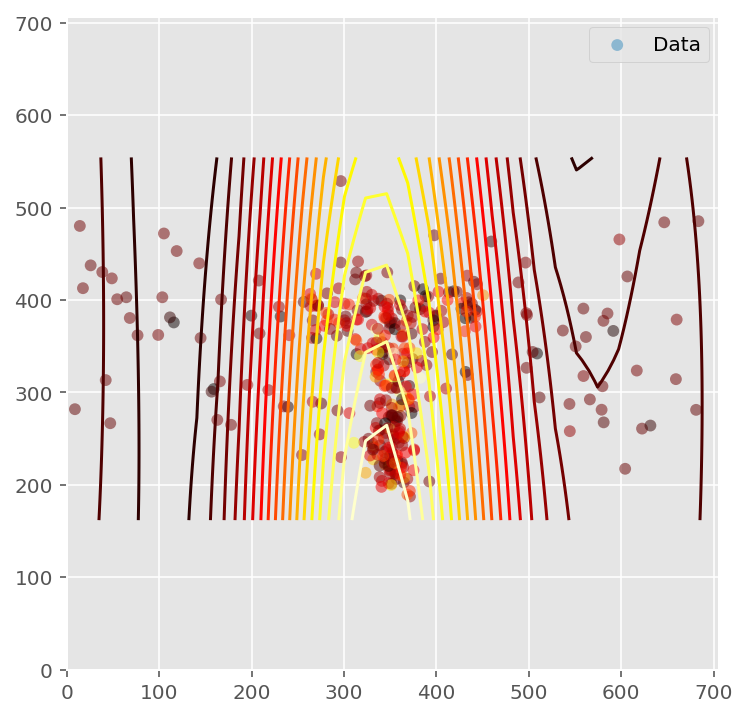

In [10]:
ker = GPy.kern.RBF(2,ARD=True)# + GPy.kern.White(2)
# create simple GP model
m = GPy.models.GPRegression(X, Y, ker)
m.randomize()
m.optimize()

_, axes = plt.subplots(1, 1, figsize=(6, 6))
m.plot(ax=axes)
axes.set(xlim=(0, xSize), ylim=(0, ySize))
axes.set_aspect('equal')

In [34]:
import GPflow

#build the model
# k = GPflow.kernels.RBF(1,ARD=False)
u = GPflow.mean_functions.Constant()
k = GPflow.kernels.RBF(2, ARD=False) + GPflow.kernels.Bias(1)
m = GPflow.gpr.GPR(X, Y, k, mean_function=u)

m.kern.rbf.lengthscales.prior = GPflow.priors.Gamma(1., 1.)
m.kern.rbf.variance.prior = GPflow.priors.Gamma(1.,1.)
m.kern.bias.variance.prior = GPflow.priors.Gamma(1.,1.)

# m.kern.lengthscales.prior = GPflow.priors.Gamma(1., 1.)
# m.kern.variance.prior = GPflow.priors.Gamma(1.,1.)

m.optimize(maxiter=15) # start near MAP
samples = m.sample(2000, verbose=True, epsilon=0.1, Lmax=15)

Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  100.0 %
Iteration:  300 	 Acc Rate:  98.0 %
Iteration:  400 	 Acc Rate:  100.0 %
Iteration:  500 	 Acc Rate:  100.0 %
Iteration:  600 	 Acc Rate:  100.0 %
Iteration:  700 	 Acc Rate:  100.0 %
Iteration:  800 	 Acc Rate:  99.0 %
Iteration:  900 	 Acc Rate:  100.0 %
Iteration:  1000 	 Acc Rate:  99.0 %
Iteration:  1100 	 Acc Rate:  100.0 %
Iteration:  1200 	 Acc Rate:  100.0 %
Iteration:  1300 	 Acc Rate:  100.0 %
Iteration:  1400 	 Acc Rate:  100.0 %
Iteration:  1500 	 Acc Rate:  100.0 %
Iteration:  1600 	 Acc Rate:  99.0 %
Iteration:  1700 	 Acc Rate:  100.0 %
Iteration:  1800 	 Acc Rate:  100.0 %
Iteration:  1900 	 Acc Rate:  100.0 %
Iteration:  2000 	 Acc Rate:  100.0 %


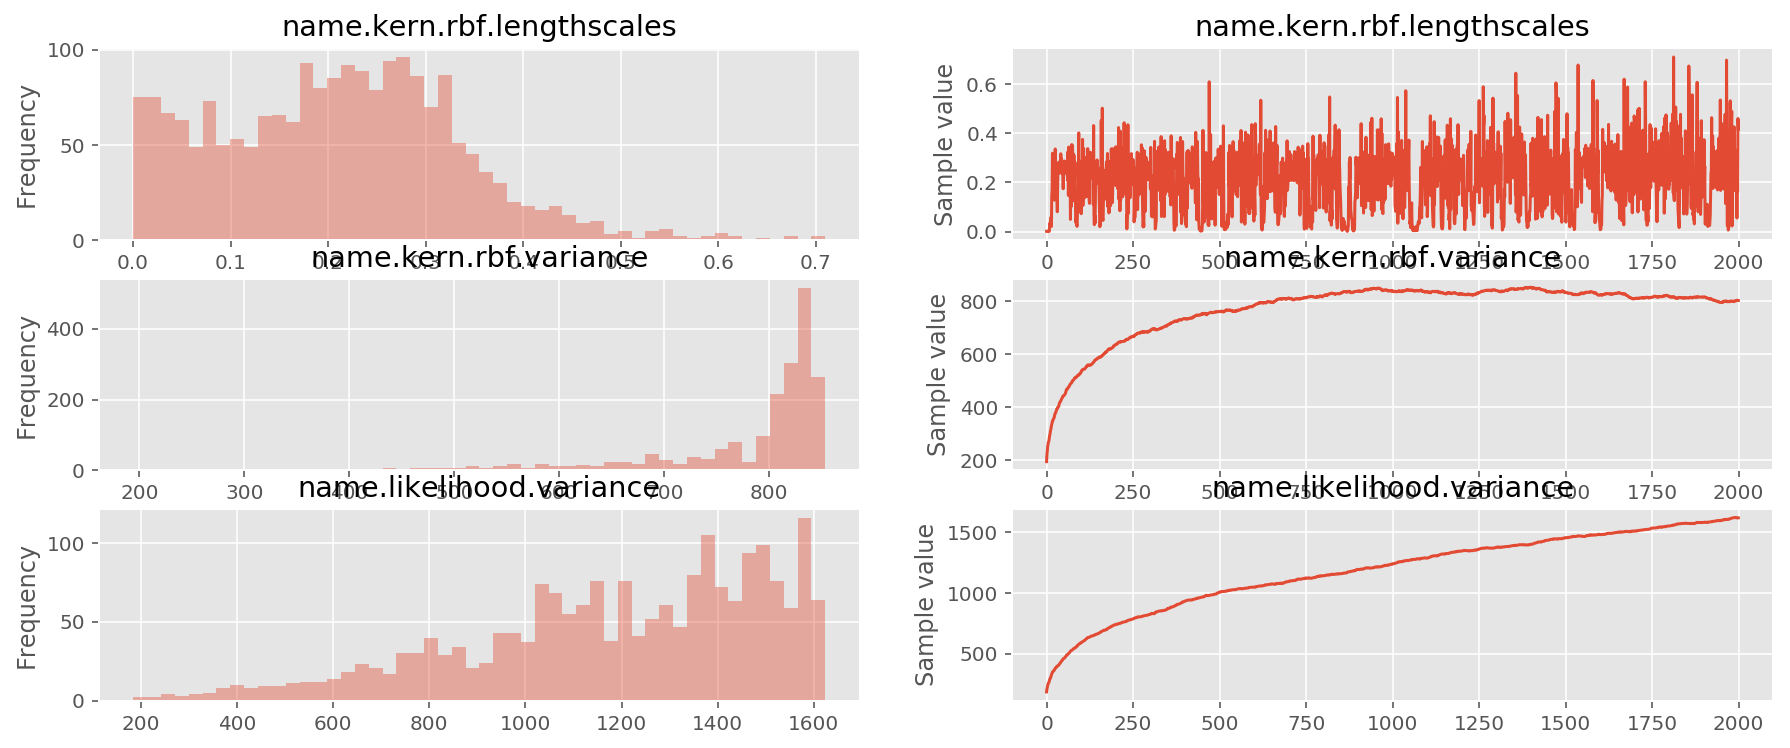

In [37]:
f, ax = plt.subplots(3, 2, figsize=(15,6))
parameter_samples = m.get_samples_df(samples)
for ii, col in enumerate(parameter_samples.columns.sort_values()[1:-1]):
    temp = np.asarray(parameter_samples[col])
    ax[ii,0].hist(temp,alpha=0.4, bins=50)
    ax[ii,0].set_title(str(col))
    ax[ii,1].plot(temp)
    ax[ii,1].set_title(str(col))
    ax[ii, 0].set_ylabel("Frequency")
    ax[ii, 1].set_ylabel("Sample value")
plt.show()

In [71]:
n=Y.shape[0]
import theano.tensor as tt
with pm.Model() as model:
    # priors on the covariance function hyperparameters
    l = pm.HalfCauchy('l', beta=3, shape=2) 
    
    # prior on the function variance
    s2_f = pm.HalfCauchy('s2_f', beta=2)
    
    # prior on the noise variance
    s2_n = pm.HalfCauchy('s2_n', beta=2)
    
    # covariance functions for the function f and the noise
    f_cov = s2_f * pm.gp.cov.ExpQuad(2, l)

#     intercept = pm.Cauchy('b',alpha=0,beta=10)
#     meanfuc = pm.gp.mean.Constant()
    
#     y_obs = pm.gp.GP('y_obs', 
#                      cov_func=f_cov, 
#                      sigma=s2_n,
#                      observed={'X':X, 'Y':Y})
    Sigma = f_cov(X) + tt.eye(n)*s2_n**2
    
    y_obs = pm.MvNormal('y_obs', mu=0, cov=Sigma, observed=Y)
#     trace = pm.sample(2000, njobs=2, tune=1000)
    
    # New ADVI api
    s = theano.shared(pm.floatX(1))
    inference = pm.FullRankADVI(cost_part_grad_scale=s)
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace = approx.sample_vp(2000) 
    
    elbos1 = -inference.hist

Average Loss = 2,731.3: 100%|██████████| 20000/20000 [13:19<00:00, 25.03it/s]  
Finished [100%]: Average Loss = 2,731.3
Average Loss = 2,659.7: 100%|██████████| 10000/10000 [05:21<00:00, 39.35it/s]
Finished [100%]: Average Loss = 2,659.5


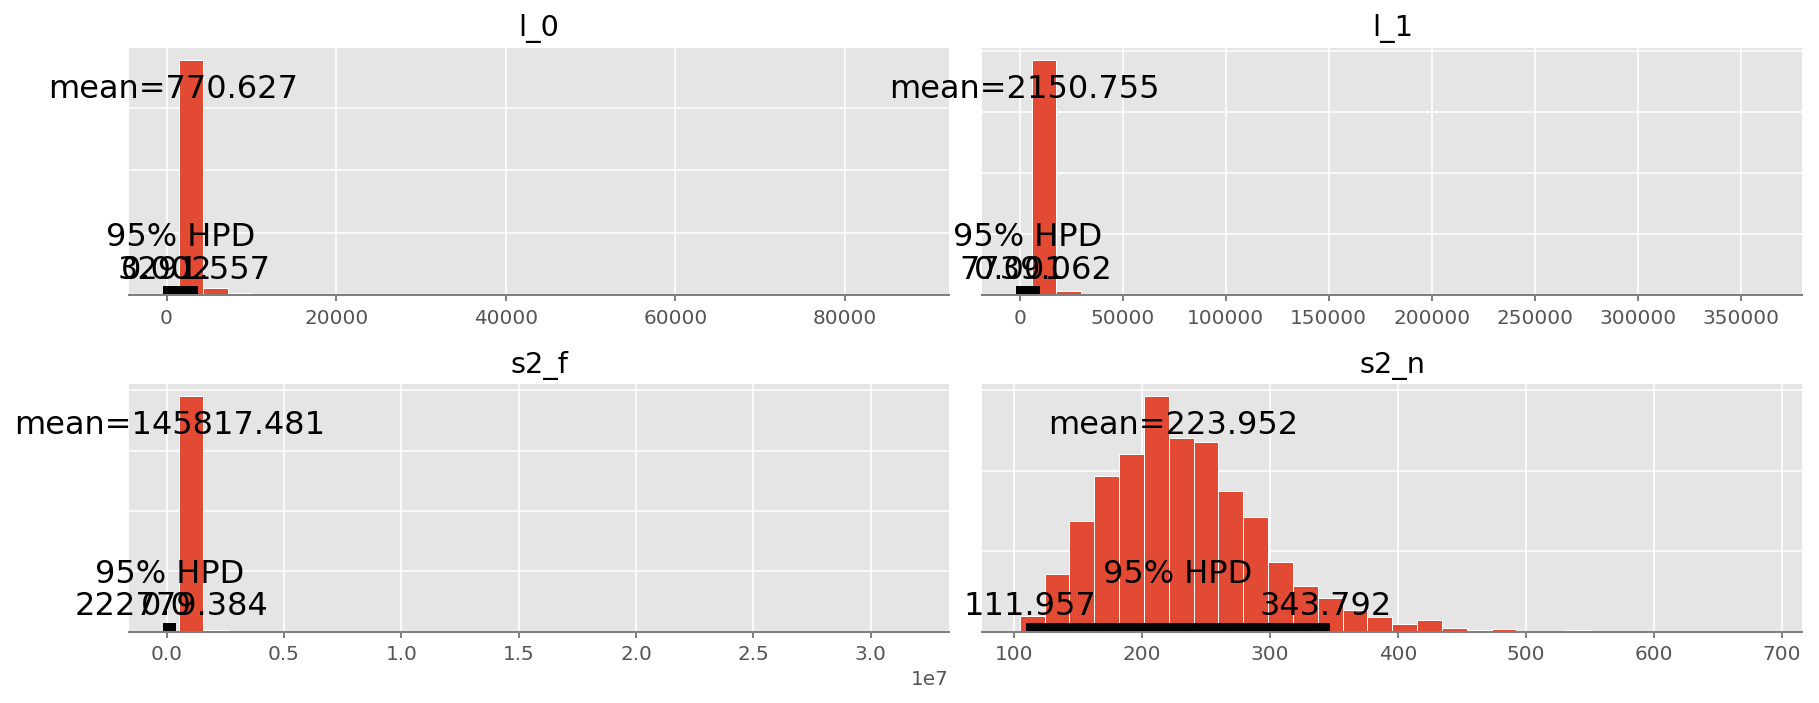

In [63]:
temp_trace = trace
pm.posteriorplot(temp_trace, varnames=['l', 's2_f', 's2_n']);

As shown above, almost all the parameters are estimated wrong. That's because the observed value (fixation duration) in 2D is very sparse. Consider the following simple case:

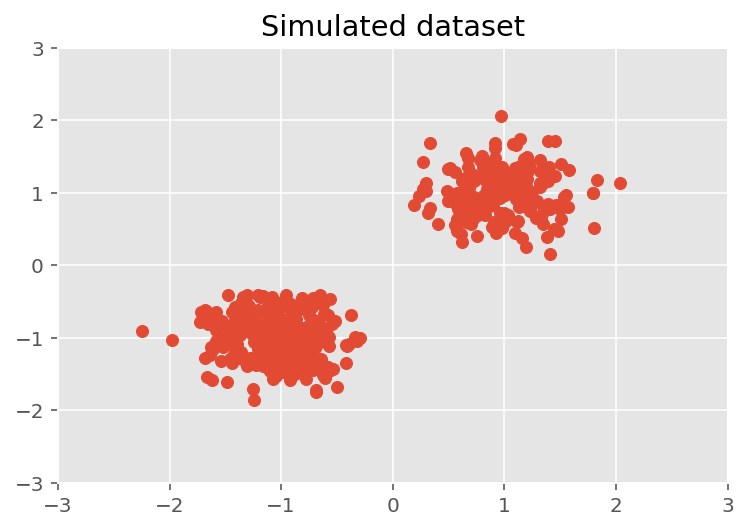

In [11]:
def build_toy_dataset(N):
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = [[0.1, 0.1], [0.1, 0.1]]
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N):
        k = np.argmax(np.random.multinomial(1, pi))
        x[n, :] = np.random.multivariate_normal(mus[k], np.diag(stds[k]))
    return x


N = 500  # number of data points
K = 2  # number of components
D = 2  # dimensionality of data
#ed.set_seed(42)

# DATA
x_train = build_toy_dataset(N)
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.axis([-3, 3, -3, 3])
plt.title("Simulated dataset")
plt.show()

defaulting to <GPy.inference.latent_function_inference.expectation_propagation.EP object at 0x10fdcd358> for latent function inference


 /Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


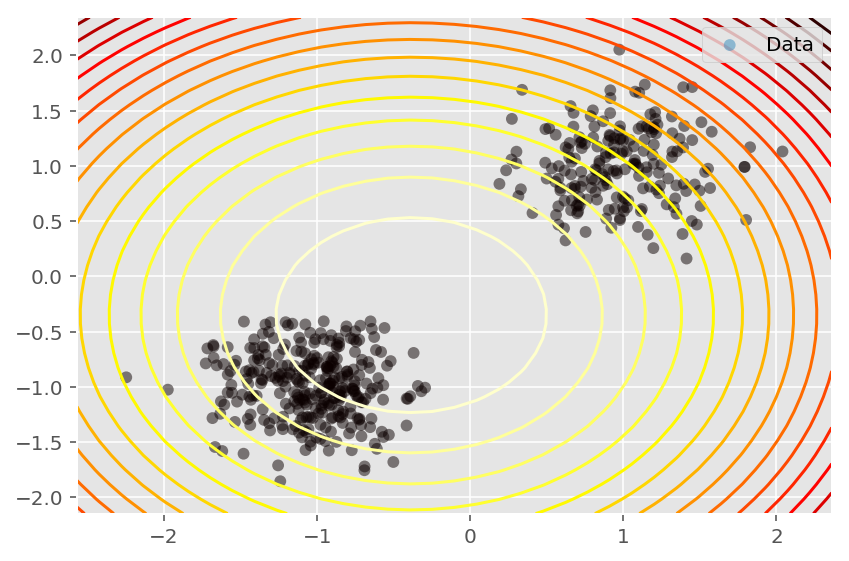

In [12]:
y = np.ones([len(x_train),1])
ker = GPy.kern.RBF(2,ARD=True)# + GPy.kern.White(2)

# create simple GP model
lik = GPy.likelihoods.Bernoulli()
m = GPy.core.GP(x_train,y,likelihood=lik,kernel=ker)

# optimize and plot
m.optimize()
m.plot();

As shown above, fitting 2D sparse data is not suitable with only a simple GP with covariance function. In fact, even in 1D, similar data (poisson process, or count data in a fixed time window) need to take into account the non-occured event (zeros), usually using a bining/historgam process.

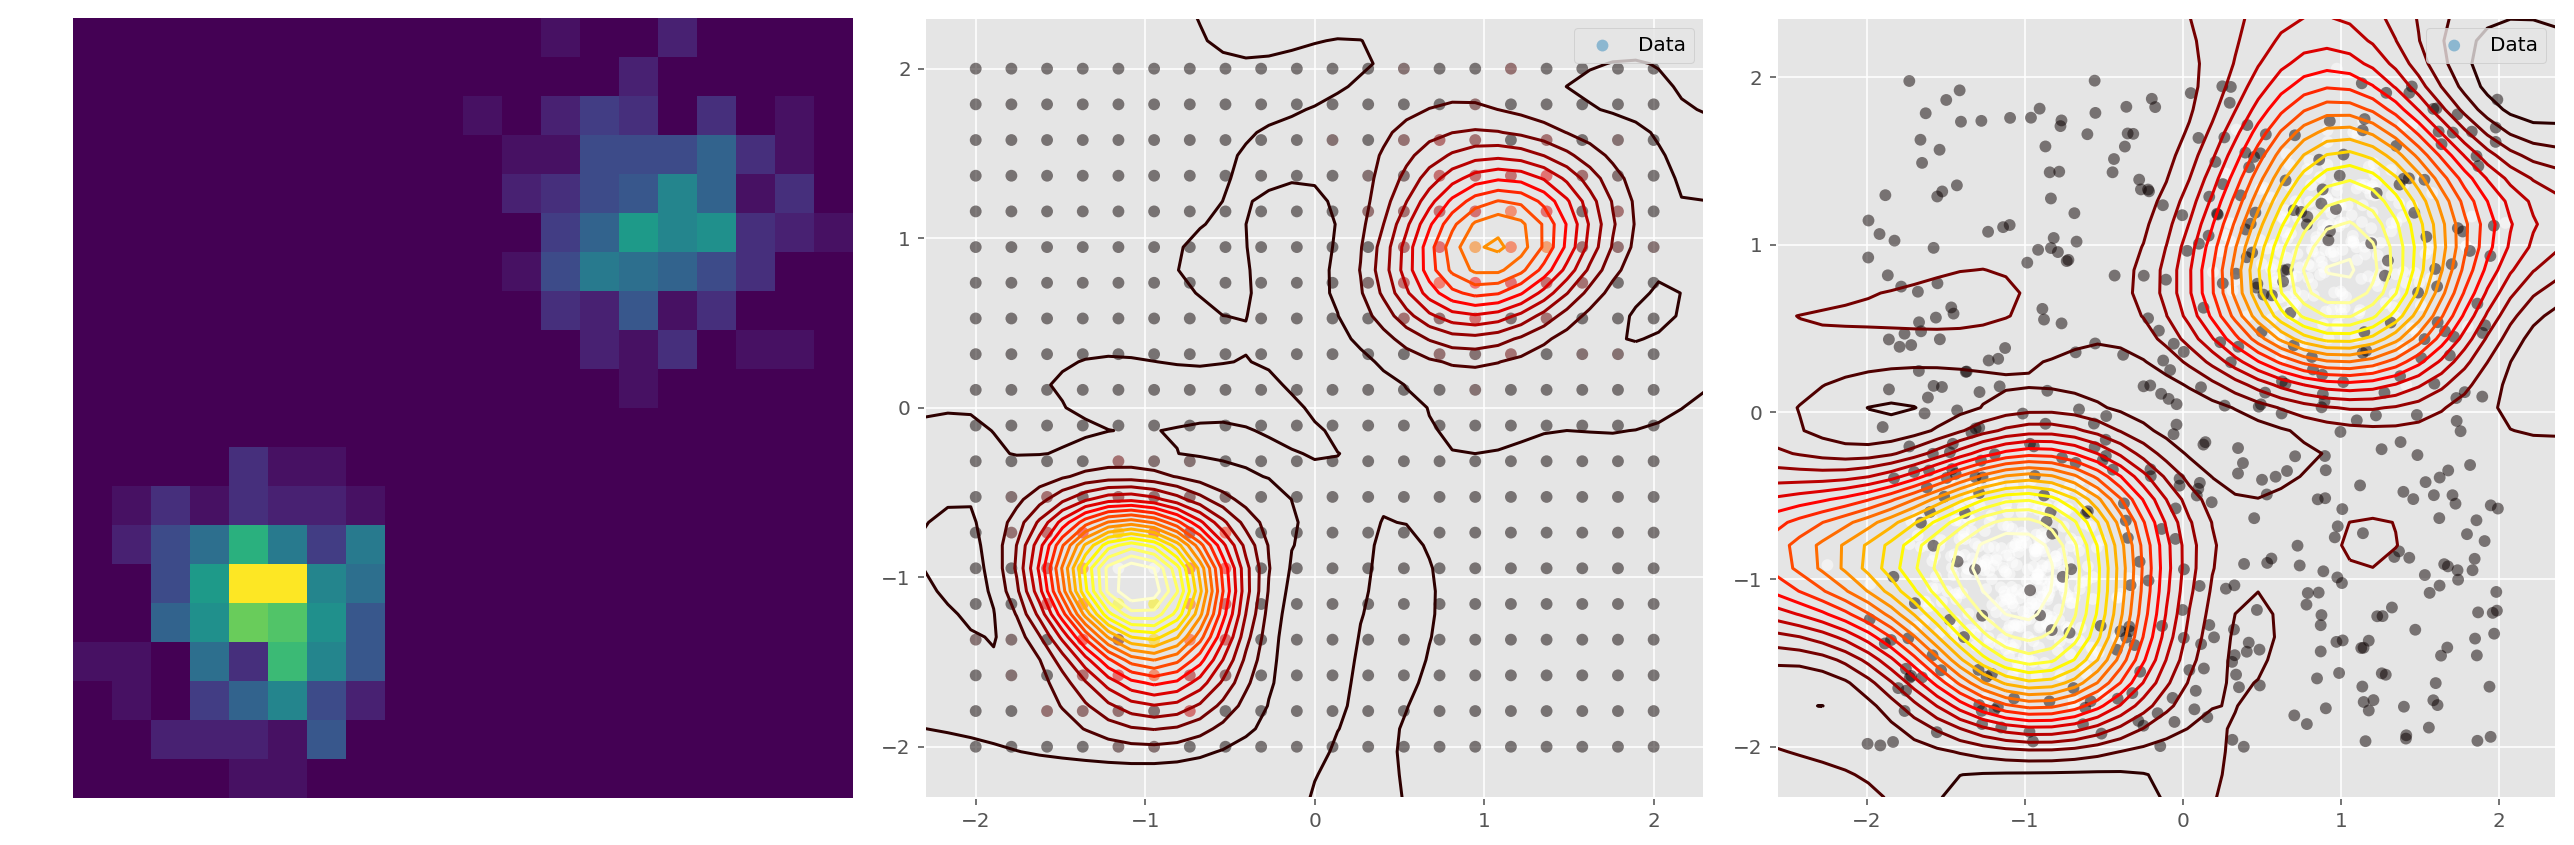

In [22]:
sizexy=20
scale =sizexy/4.
y1_ = (x_train[:,0]+2)*scale
x1_ = (x_train[:,1]+2)*scale
col = np.asarray(x1_,dtype=int)
col[col==20]=19
col[col<0]=0
row = np.asarray(y1_,dtype=int)
row[row==20]=19
row[row<0]=0

dur = np.asarray(y.flatten())
from scipy.sparse import coo_matrix
rawmap = coo_matrix((dur, (row, col)), shape=(sizexy, sizexy)).toarray()
f, axes1 = plt.subplots(1, 3, figsize=(18, 6))

axes1[0].imshow(rawmap,cmap='viridis',interpolation='none',origin='lower')
axes1[0].axis('off')

x1 = np.linspace(-2, 2, sizexy)
y1 = np.linspace(-2, 2, sizexy)
xx, yy = np.meshgrid(x1, y1)

Xtrain2 = np.hstack((np.reshape(xx,(sizexy**2,1)),np.reshape(yy,(sizexy**2,1))))
Ytrain2 = np.reshape(rawmap,(sizexy**2,1))

kg2 = GPy.kern.RBF(2,ARD=True)

mm2 = GPy.models.GPRegression(Xtrain2, Ytrain2, kernel=kg2)
#xtmp = np.vstack((col,row)).transpose()
#mm2 = GPy.models.GPRegressionGrid(xtmp, y,kernel=kg2)

mm2.optimize()
mm2.plot(ax=axes1[1])

#kg = GPy.kern.RBF(1, active_dims=[0],ARD=False) * GPy.kern.RBF(1, active_dims=[1],ARD=False)
kg = GPy.kern.RBF(2,ARD=True)

x_train2=(np.random.rand(x_train.shape[0],x_train.shape[1])-.5)*4
Xtrain = np.vstack((x_train,x_train2))
Ytrain = np.vstack((y,np.zeros((len(x_train),1))))

mm = GPy.models.GPRegression(Xtrain, Ytrain, kernel=kg)
#lik = GPy.likelihoods.Bernoulli()
#mm = GPy.core.GP(Xtrain, Ytrain, kernel=kg,likelihood=lik)
mm.optimize()
mm.plot(ax=axes1[2])

plt.tight_layout();

Bining the data works, but we need to downsample quite a lot, and it is impossible to scale to higher dimension. Alternatively, just fill in some zeros in the empty space.  
Adding some mean function also can help with this problem, but really it is another approach (covariance function might become redundent in this case):

In [ ]:
#mf = GPy.mappings.Kernel(2, 1, np.random.normal(0,1,(1,2)), 
#                                               GPy.kern.RBF(2))
mf = GPy.mappings.Additive(GPy.mappings.Kernel(2, 1, np.random.normal(0,.1,(1,2))+[-1,-1], 
                                               GPy.kern.RBF(2)), 
                           GPy.mappings.Kernel(2, 1, np.random.normal(0,.1,(1,2))+[1,1], 
                                               GPy.kern.RBF(2))
                           )
# define kernel
# ker = GPy.kern.RBF(1, active_dims=[0],ARD=False) * GPy.kern.RBF(1, active_dims=[1],ARD=False)
ker = GPy.kern.RBF(2,ARD=True)# + GPy.kern.White(2)

# create simple GP model
lik = GPy.likelihoods.Bernoulli()
m = GPy.core.GP(x_train,y,likelihood=lik,kernel=ker,mean_function=mf)

# optimize and plot
m.optimize()
m.plot();

Now we applied the bining approach and the added random (fake) sample approach to the eye movement data.

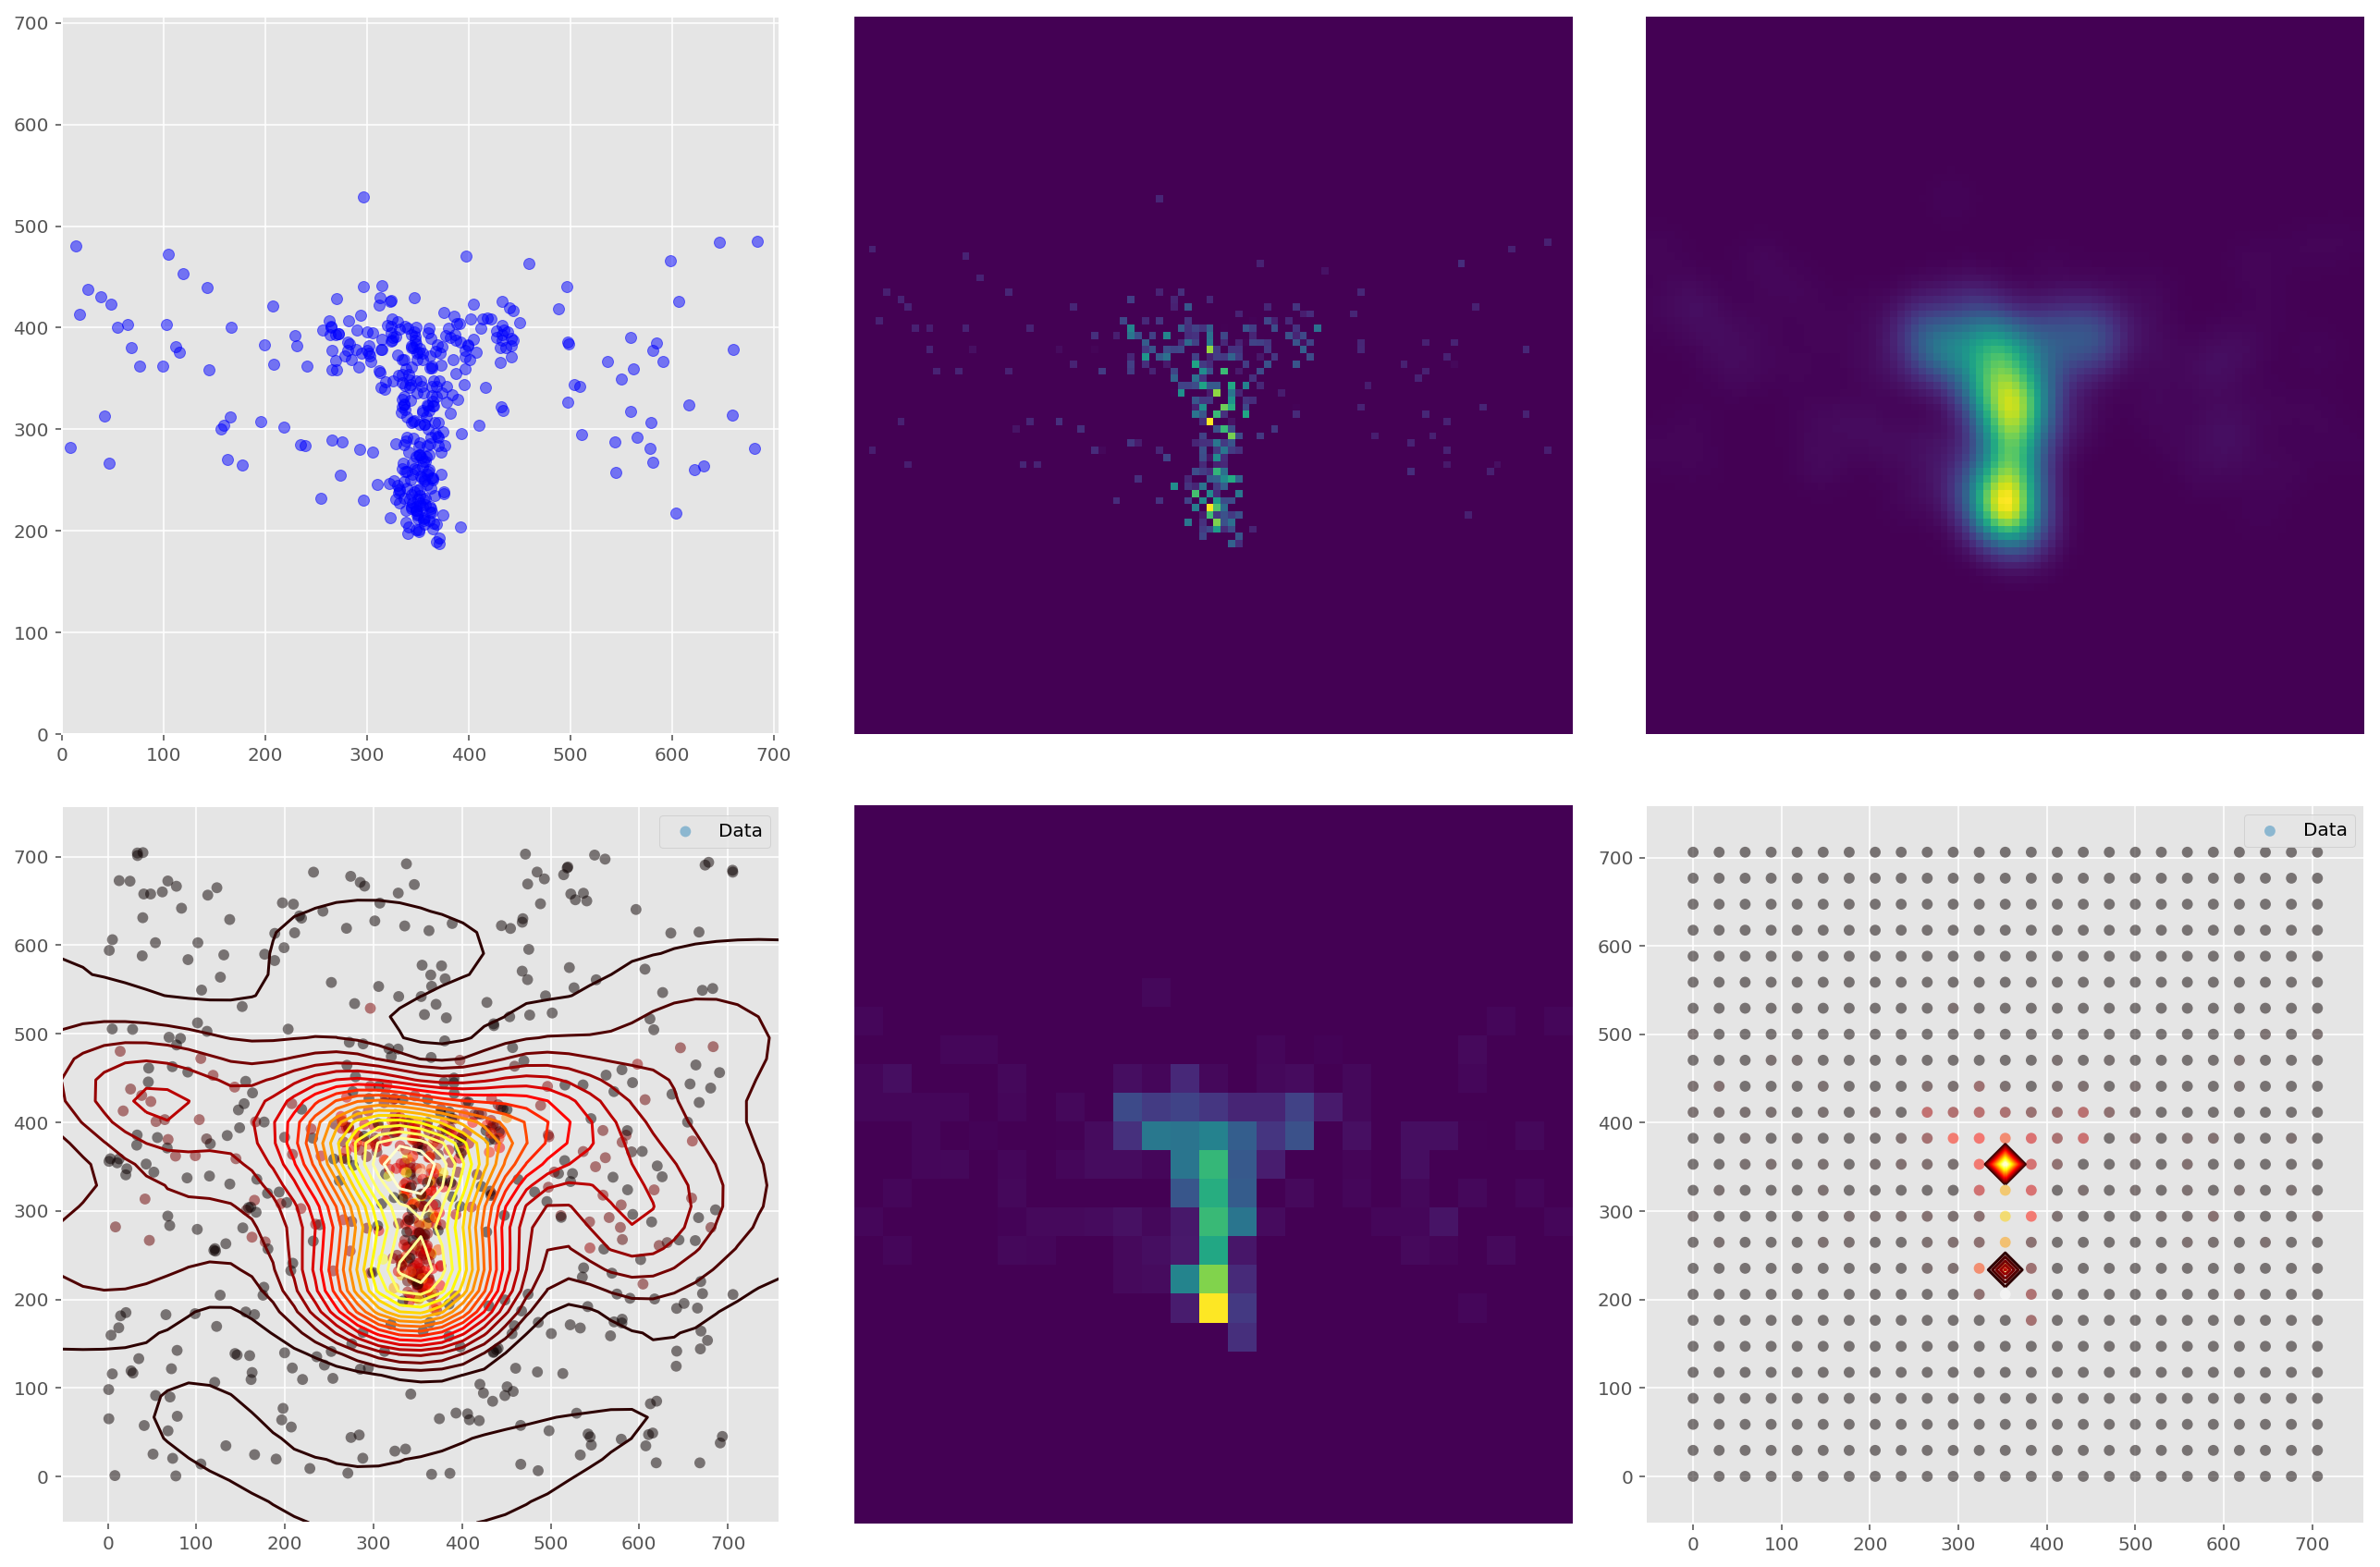

In [23]:
f, axes1 = plt.subplots(2, 3, figsize=(18, 12))

axes1[0,0].scatter(xfix[idx1],ySize-yfix[idx1],\
            alpha=.5, color='b')
axes1[0,0].set(xlim=(0, xSize), ylim=(0, ySize), )
axes1[0,0].set_aspect('equal')

col = np.asarray(xfix[idx1],dtype=int)
row = np.asarray(yfix[idx1],dtype=int)
dur = np.asarray(fixdur[idx1])
indexnew = (col>=0)&(col<xSize)&(row>=0)&(row<ySize)
rawmap = coo_matrix((dur[indexnew], (row[indexnew], col[indexnew])), shape=(xSize, ySize)).toarray()

xSize_rz, ySize_rz = 100,100
col_rz = np.digitize(xfix[idx1], np.linspace(0,xSize,xSize_rz))
row_rz = np.digitize(yfix[idx1], np.linspace(0,ySize,ySize_rz))
indexnew = (col_rz>=0)&(col_rz<xSize_rz)&(row_rz>=0)&(row_rz<ySize_rz)
rawmaprz = coo_matrix((dur[indexnew], (row_rz[indexnew], col_rz[indexnew])), shape=(xSize_rz, ySize_rz)).toarray()
axes1[0,1].imshow(rawmaprz,cmap='viridis',interpolation='none')
axes1[0,1].axis('off')

smoothpic = gaussian_filter(rawmaprz, sigma_smooth/(xSize/xSize_rz))
axes1[0,2].imshow(smoothpic,cmap='viridis',interpolation='none')
axes1[0,2].axis('off')

# random sample from empty space for zeros
x_train2=(np.random.rand(X.shape[0],X.shape[1]))*xSize
Xtrain = np.vstack((X,x_train2))
Ytrain = np.vstack((Y,np.zeros((len(X),1))))

# define kernel
ker = GPy.kern.RBF(2, ARD=True)# + GPy.kern.White(2)
# create simple GP model
m = GPy.models.GPRegression(Xtrain,Ytrain,ker)
# optimize and plot
m.optimize()

sizexy=25
scale =sizexy/xSize
xfix_ = (X[:,0]+2)*scale
yfix_ = (X[:,1]+2)*scale
col = np.asarray(xfix_,dtype=int)
col[col>=sizexy]=sizexy-1
row = np.asarray(yfix_,dtype=int)
row[row>=sizexy]=sizexy-1

dur = np.asarray(Y.flatten())
rawmap = coo_matrix((dur, (row, col)), shape=(sizexy, sizexy)).toarray()
m.plot(ax=axes1[1,0])
axes1[1,0].set_aspect('equal')

axes1[1,1].imshow(rawmap,cmap='viridis',interpolation='none',origin='lower')
axes1[1,1].axis('off')

x1 = np.linspace(0, xSize, sizexy)
y1 = np.linspace(0, xSize, sizexy)
xx, yy = np.meshgrid(x1, y1)

Xtrain2 = np.hstack((np.reshape(xx,(sizexy**2,1)),np.reshape(yy,(sizexy**2,1))))
Ytrain2 = np.reshape(rawmap,(sizexy**2,1))

kg2 = GPy.kern.RBF(2, ARD=True)
mm2 = GPy.models.GPRegression(Xtrain2, Ytrain2, kernel=kg2)
mm2.optimize()
mm2.plot(ax=axes1[1,2])
axes1[1,2].set_aspect('equal')

f.tight_layout()

As shown above, using frequensitic approach the length scale is not estimated properly (actually, the bining size has a strong effect on it). This is easy to resolve using Bayesian approach by putting an informative prior on length scale.

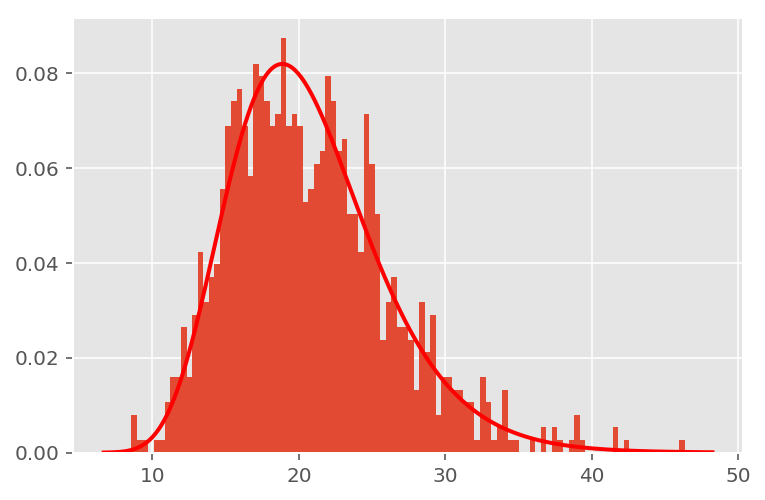

In [32]:
#%% 2D count data 
sizexy=25
rawmap,x0,y0 = np.histogram2d(X[:,1],X[:,0],bins=sizexy)
x1 = np.diff(x0)+x0[:-1]
y1 = np.diff(y0)+y0[:-1]
xx, yy = np.meshgrid(x1, y1)

X2 = np.hstack((np.reshape(xx,(sizexy**2,1)),np.reshape(yy,(sizexy**2,1))))
#X2 = np.reshape(xx,(sizexy**2,1))
Y2 = np.reshape(rawmap,(sizexy**2,1))

#X2 = np.expand_dims(X[:,1],axis=1)
#X2 = np.sort(X2,axis=0)
#Y2 = np.ones((len(X),1))
#Y2 = np.expand_dims(np.cumsum(Y2),axis=1)
lik = GPy.likelihoods.Poisson()

N, nd = X2.shape
k2 = GPy.kern.RBF(nd, ARD=True)

laplace_inf = GPy.inference.latent_function_inference.Laplace()
m = GPy.core.GP(X2, Y2, kernel=k2, likelihood=lik, inference_method=laplace_inf)

#m.kern.lengthscale.randomize()
#print(m.kern.lengthscale)
lognormal = GPy.priors.LogGaussian(mu=3, sigma=.25) # mode at 1degree
lognormal.plot()
m.kern.set_prior(lognormal)

# optimize and plot
m.randomize()
m.optimize()

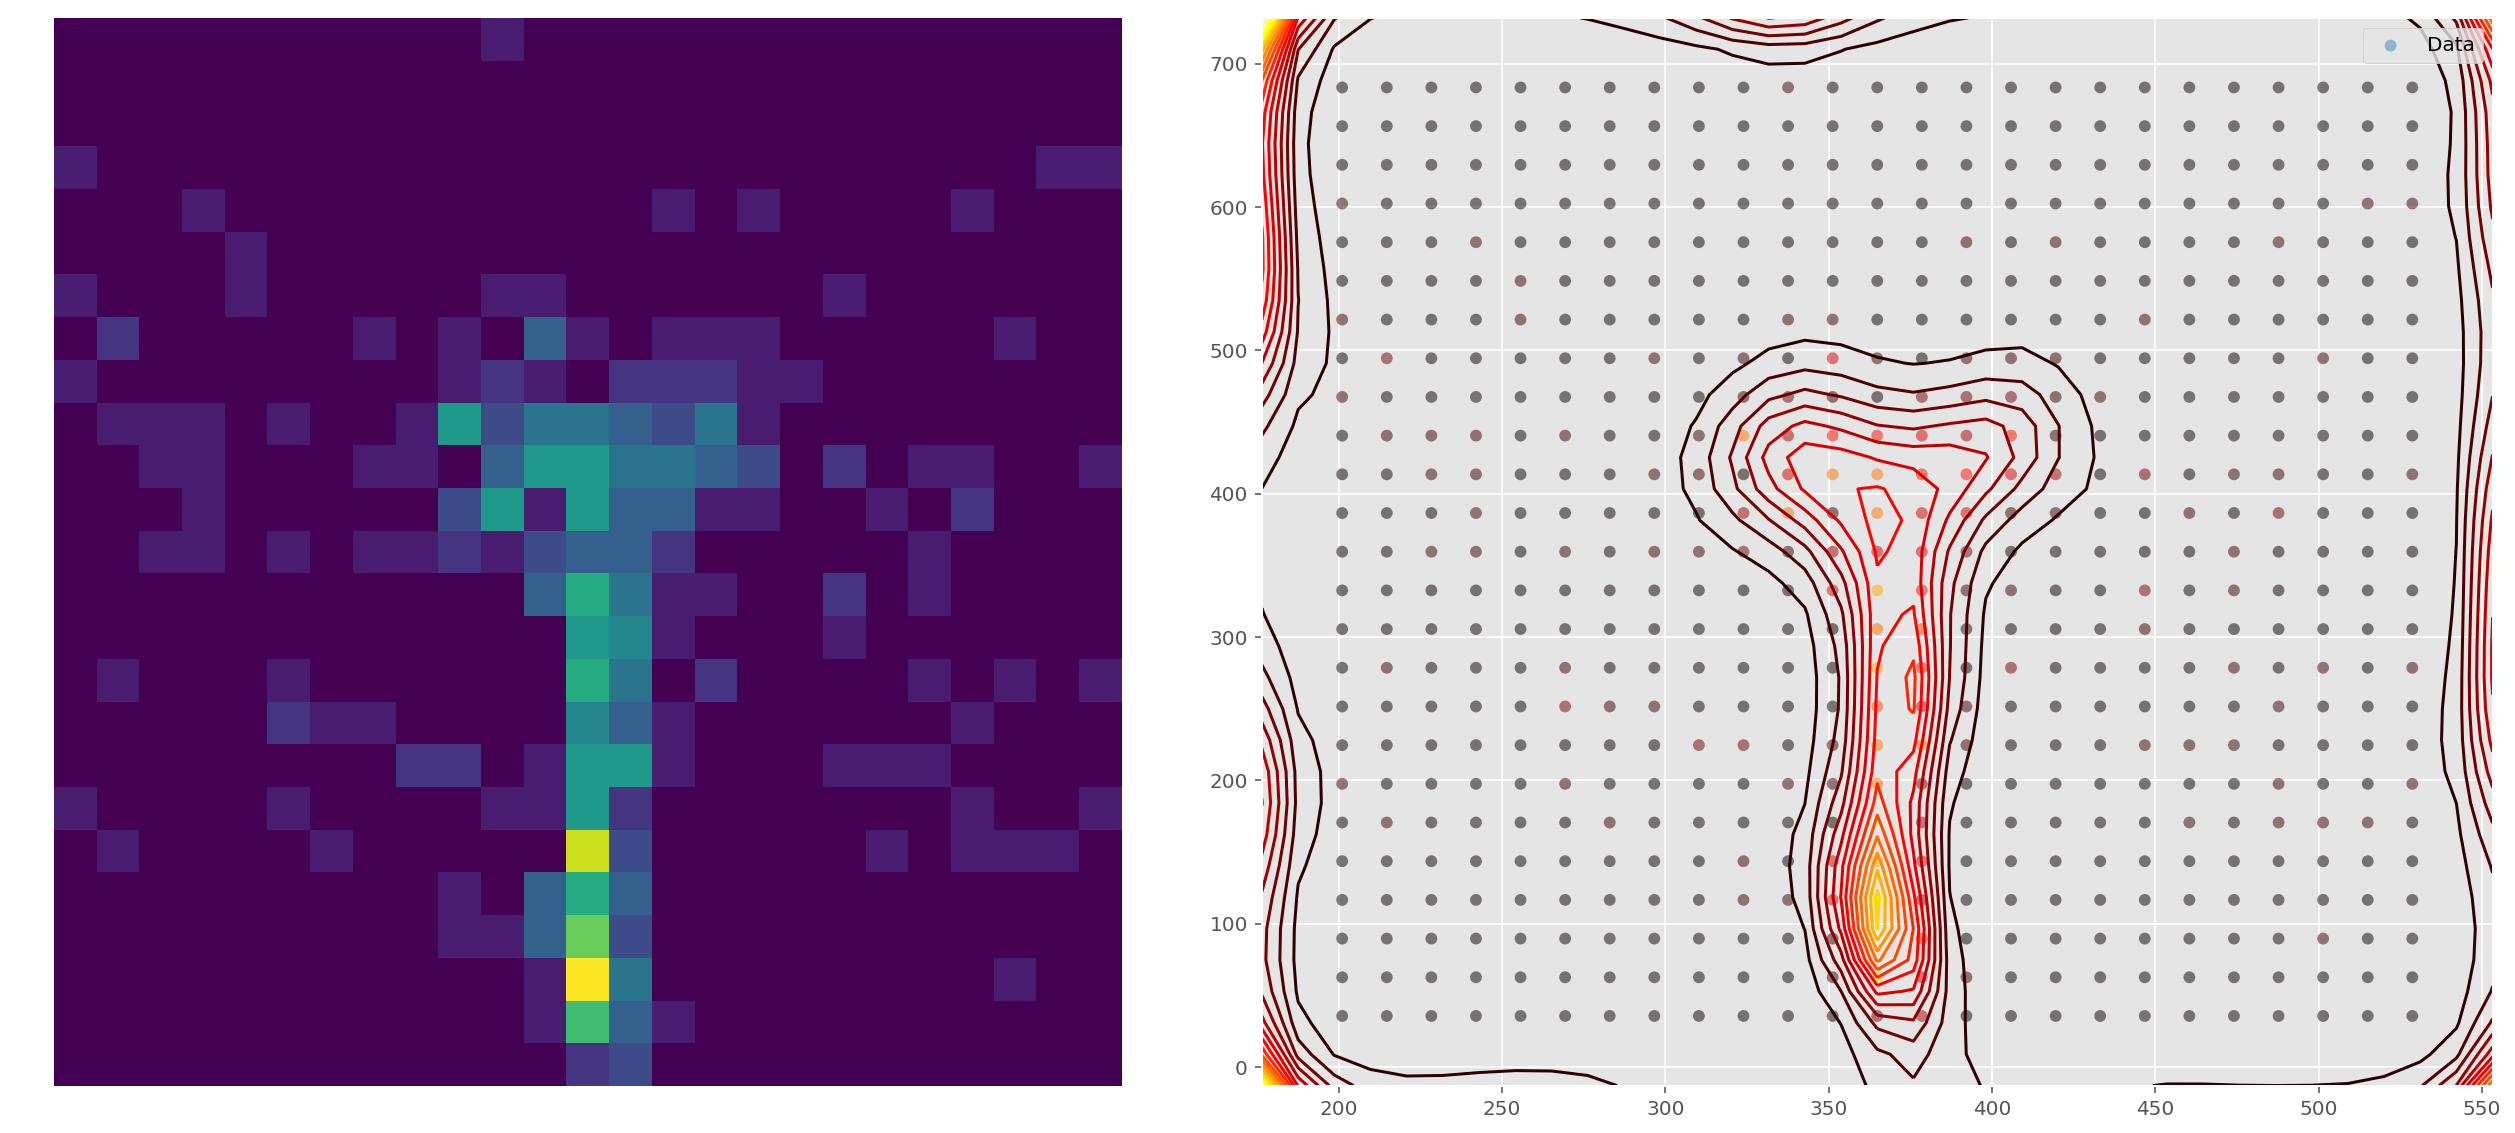

In [31]:
f, axes2 = plt.subplots(1, 2, figsize=(18, 8))
axes2[0].imshow(rawmap,cmap='viridis',interpolation='none',origin='lower')
axes2[0].axis('off')
m.plot(ax=axes2[1])
axes2[1].set_aspect('auto')
plt.tight_layout()

# Bayesian via MCMC (in GPflow)

In [37]:
import GPflow
# k = GPflow.kernels.RBF(1,ARD=False)
u = GPflow.mean_functions.Constant()
k = GPflow.kernels.RBF(2, ARD=False) + GPflow.kernels.Bias(1)
m = GPflow.gpr.GPR(X2, Y2, k, mean_function=u)

m.kern.rbf.lengthscales.prior = GPflow.priors.LogNormal(mu=3, var=.5) # mode at 1degree
m.kern.rbf.variance.prior = GPflow.priors.Gamma(1.,1.)
m.kern.bias.variance.prior = GPflow.priors.Gamma(1.,1.)

# m.kern.lengthscales.prior = GPflow.priors.Gamma(1., 1.)
# m.kern.variance.prior = GPflow.priors.Gamma(1.,1.)

m.optimize(maxiter=15) # start near MAP
samples = m.sample(2000, verbose=True, epsilon=0.1, Lmax=15)

Iteration:  100 	 Acc Rate:  95.0 %
Iteration:  200 	 Acc Rate:  95.0 %
Iteration:  300 	 Acc Rate:  94.0 %
Iteration:  400 	 Acc Rate:  95.0 %
Iteration:  500 	 Acc Rate:  98.0 %
Iteration:  600 	 Acc Rate:  97.0 %
Iteration:  700 	 Acc Rate:  92.0 %
Iteration:  800 	 Acc Rate:  95.0 %
Iteration:  900 	 Acc Rate:  96.0 %
Iteration:  1000 	 Acc Rate:  95.0 %
Iteration:  1100 	 Acc Rate:  96.0 %
Iteration:  1200 	 Acc Rate:  94.0 %
Iteration:  1300 	 Acc Rate:  97.0 %
Iteration:  1400 	 Acc Rate:  91.0 %
Iteration:  1500 	 Acc Rate:  97.0 %
Iteration:  1600 	 Acc Rate:  96.0 %
Iteration:  1700 	 Acc Rate:  98.0 %
Iteration:  1800 	 Acc Rate:  97.0 %
Iteration:  1900 	 Acc Rate:  94.0 %
Iteration:  2000 	 Acc Rate:  92.0 %


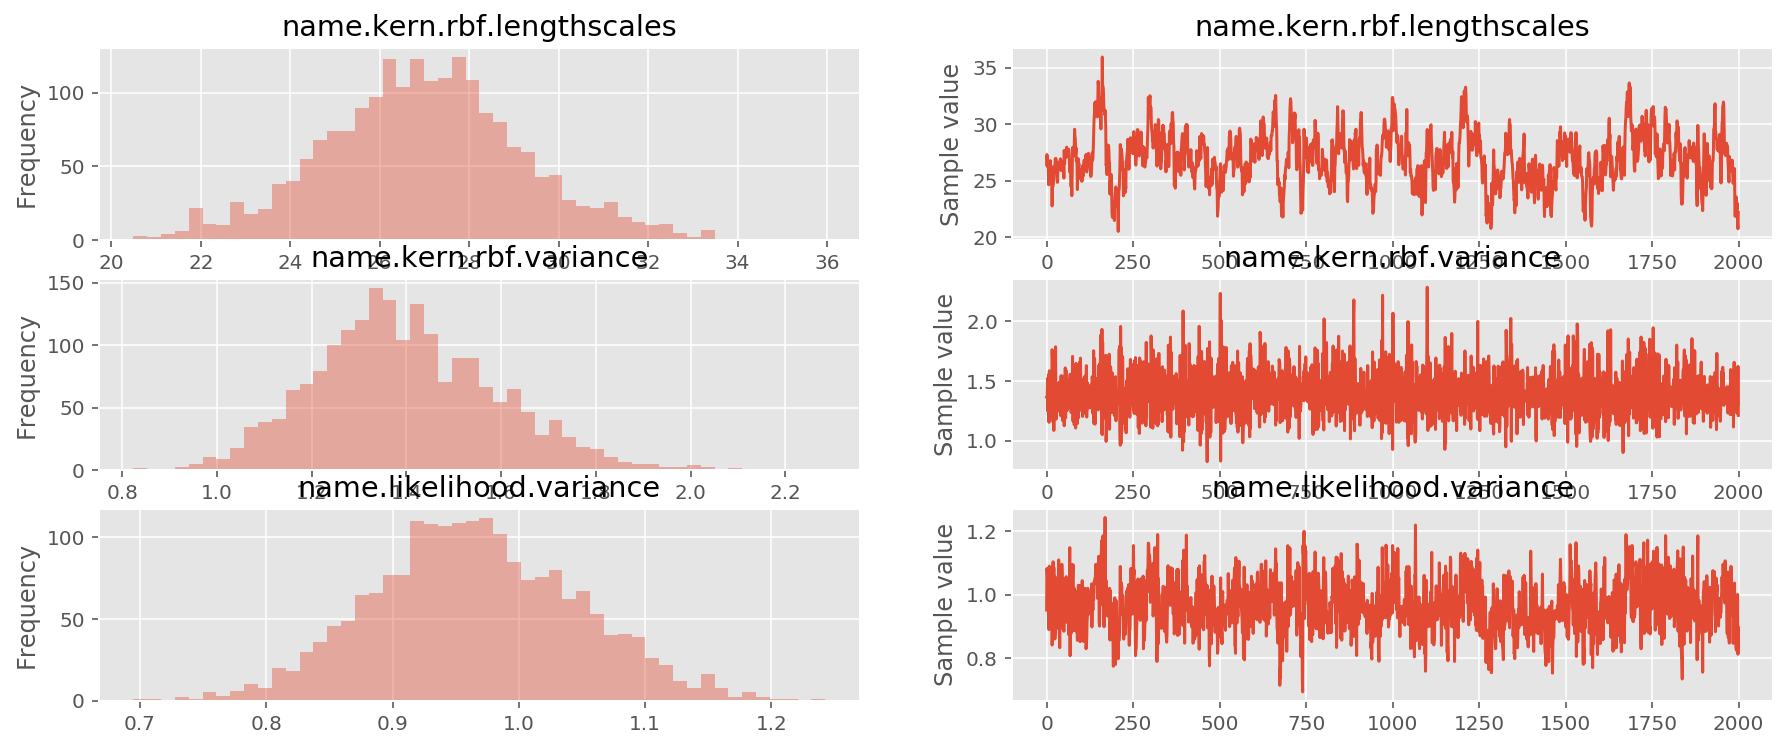

In [38]:
f, ax = plt.subplots(3, 2, figsize=(15,6))
parameter_samples = m.get_samples_df(samples)
for ii, col in enumerate(parameter_samples.columns.sort_values()[1:-1]):
    temp = np.asarray(parameter_samples[col])
    ax[ii,0].hist(temp,alpha=0.4, bins=50)
    ax[ii,0].set_title(str(col))
    ax[ii,1].plot(temp)
    ax[ii,1].set_title(str(col))
    ax[ii, 0].set_ylabel("Frequency")
    ax[ii, 1].set_ylabel("Sample value")
plt.show()

In [46]:
parameter_samples.head(5)

name.mean_function.c name.kern.rbf.variance name.kern.rbf.lengthscales  \
0       [0.5554790067]        [1.36342968329]            [26.4066838854]   
1      [1.88059641545]        [1.36673967622]            [27.3068195039]   
2     [0.204158755501]         [1.3821620558]            [27.0136106853]   
3   [-0.0489507538147]        [1.52007747502]            [26.2360140876]   
4     [0.514014575061]        [1.24458426655]            [26.3882171056]   

  name.kern.bias.variance name.likelihood.variance  
0        [0.371328957129]         [0.952271230957]  
1         [1.43048265001]          [1.08228574996]  
2         [2.37450029495]          [1.07307779692]  
3         [3.00737281182]          [1.03264077879]  
4         [2.43816869917]         [0.960521750325]

In [58]:
l_post = parameter_samples['name.kern.rbf.lengthscales'].mean()
ker_var = parameter_samples['name.kern.rbf.variance'].mean()
bias_var = parameter_samples['name.kern.bias.variance'].mean()
lik_var = parameter_samples['name.likelihood.variance'].mean()

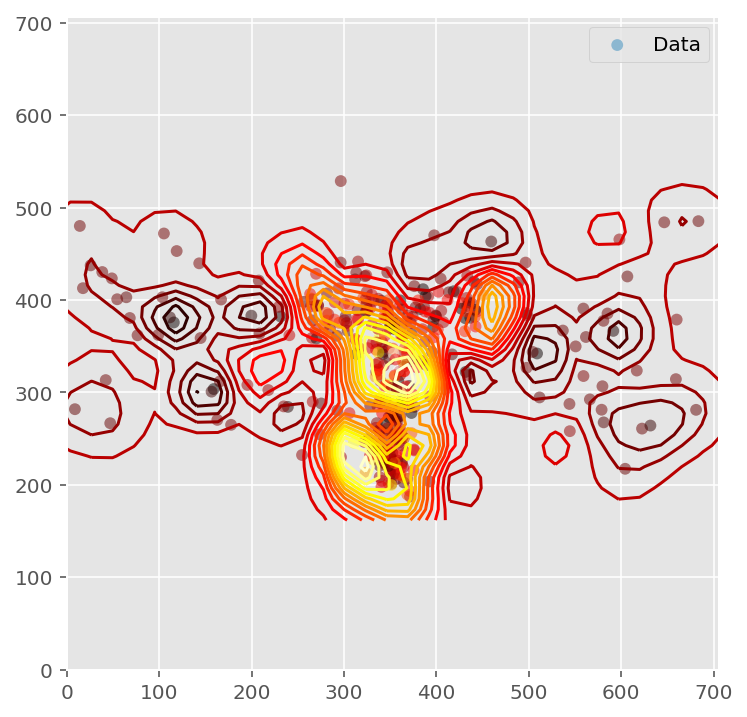

In [63]:
import GPy
ker = GPy.kern.RBF(2, ARD=True) + GPy.kern.Bias(1)
# create simple GP model
m_post = GPy.models.GPRegression(X, Y, ker)
m_post.kern.rbf.lengthscale.fix([l_post,l_post])
m_post.kern.rbf.variance.fix(ker_var)
m_post.kern.bias.variance.fix(bias_var)

m_post.likelihood.variance.fix(lik_var)
_, axes = plt.subplots(1, 1, figsize=(6, 6))
m_post.plot(ax=axes)
axes.set(xlim=(0, xSize), ylim=(0, ySize))
axes.set_aspect('equal')
plt.show()

The length scale of the kernel above is the same for both dimensions, we can also model the length scale for each dimension:

In [64]:
import theano.tensor as tt
import theano
Xshared = theano.shared(X2)
Yshared = theano.shared(Y2)

with pm.Model() as GP_fixmap:
    # priors on the covariance function hyperparameters
    l = pm.Lognormal('l', mu=3, sd=.25, shape=2) 
    
    # prior on the function variance
    s2_f = pm.Gamma('s2_f', alpha=1., beta=1.)
    
    # prior on the noise variance
    s2_n = pm.Gamma('s2_n', alpha=1., beta=1.)
    
    # covariance functions for the function f and the noise
    f_cov = s2_f * pm.gp.cov.ExpQuad(2, l)

    Sigma = f_cov(Xshared) + tt.eye(Xshared.shape[0])*s2_n**2
    
    y_obs = pm.MvNormal('y_obs', mu=0, cov=Sigma, observed=Yshared)
#     trace = pm.sample(2000, njobs=2, tune=1000)|
    
    # New ADVI api
    s = theano.shared(pm.floatX(1))
    # inference = pm.FullRankADVI(cost_part_grad_scale=s)
    inference = pm.ADVI(cost_part_grad_scale=s)
    
    # ADVI has nearly converged
    inference.fit(n=20000)
    # It is time to set `s` to zero
    s.set_value(0)
    approx = inference.fit(n=10000)
    trace = approx.sample_vp(2000) 
    
    elbos1 = -inference.hist

Average Loss = 891.44: 100%|██████████| 20000/20000 [34:04<00:00, 10.71it/s] 
Finished [100%]: Average Loss = 891.44
Average Loss = 891.46:  10%|█         | 1004/10000 [01:35<17:42,  8.47it/s]
Interrupted at 1,004 [10%]: Average Loss = 891.46


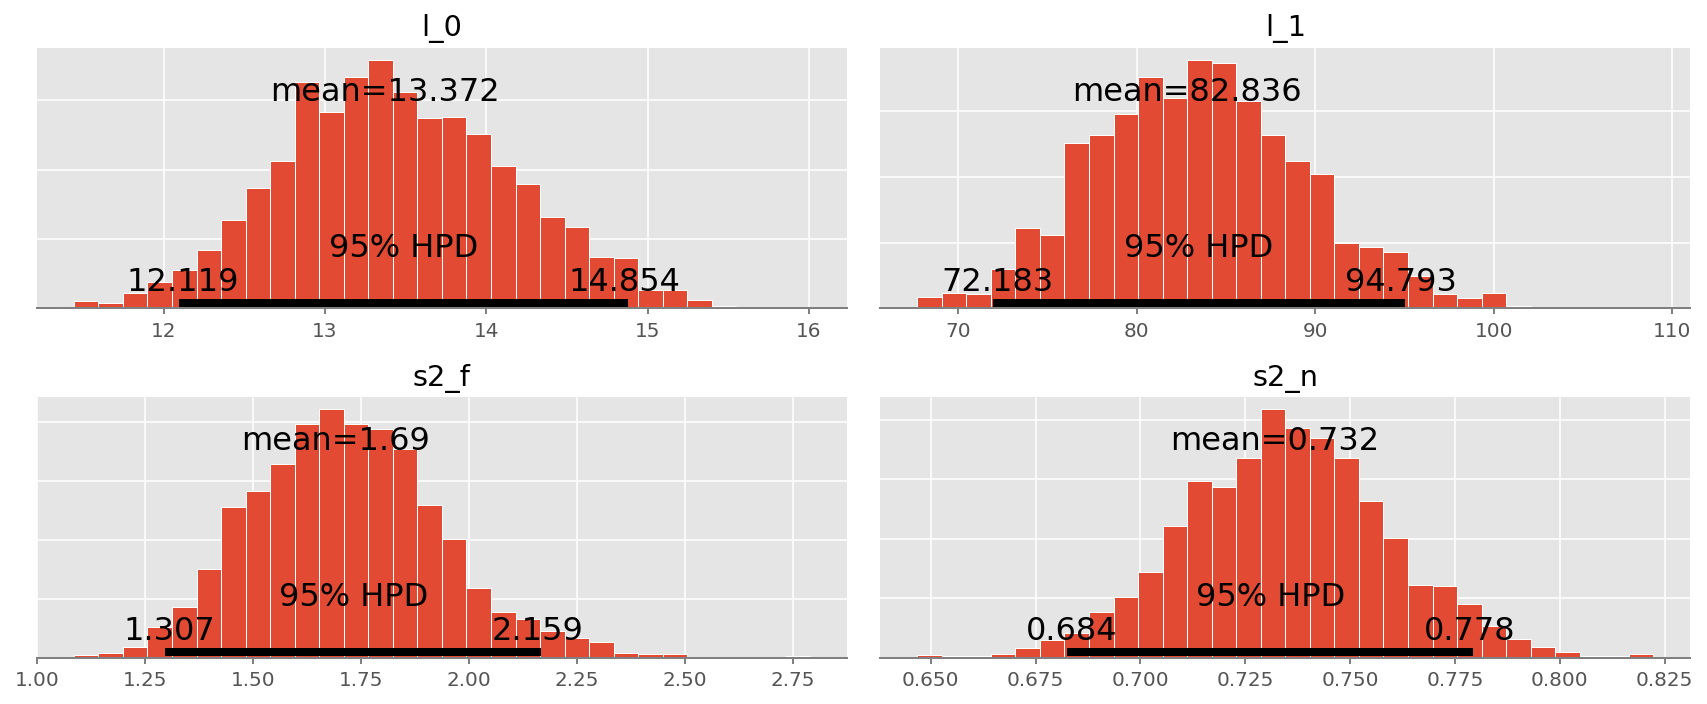

In [65]:
temp_trace = trace
pm.posteriorplot(temp_trace, varnames=['l', 's2_f', 's2_n']);

# Some remarks

* Use minibatch or SG-MCMC method to speed up the computation (it is currently under development in PyMC3)
* Maybe try SMC (Experimental in PyMC3)
* A Dirichlet Process model to map the distribution?
* Poisson Process with fixation number at location $(x_i, y_j)$ and fixation duration modeled as waiting time ($fixdur \sim \text{Gamma} (\alpha, \beta)$) of the Poisson Process.